In [1]:
import json
import w3d2_tests
import transformers
import torch

model = w3d2_tests.get_minigpt("model.pt")
tokenizer = transformers.GPT2Tokenizer.from_pretrained("gpt2")
# 50258 is the pad_token_id
# 50257 is the BEGIN token id

with open("test_tokens_owt_subset.json") as f:
    test_tokens = torch.LongTensor(json.load(f))[:,:]


In [ ]:
print(test_tokens)

tensor([[50257,   376, 32910,  ..., 50258, 50258, 50258],
        [50257,   383, 23020,  ...,   314,   373,  2252],
        [50257,  1318,   389,  ..., 50258, 50258, 50258],
        ...,
        [50257, 42272, 15773,  ..., 50258, 50258, 50258],
        [50257,   449,    54,  ...,   287,   262,  1578],
        [50257, 19020,  2198,  ...,   383, 19020,  6822]])


In [ ]:
model

MiniGPT(
  (token_embedding): Embedding(50259, 256)
  (pos_embedding): Embedding(512, 256)
  (blocks): Sequential(
    (0): UniAttention(
      (project_qkv): Linear(in_features=256, out_features=768, bias=False)
      (project_output): Linear(in_features=256, out_features=256, bias=False)
    )
    (1): UniAttention(
      (project_qkv): Linear(in_features=256, out_features=768, bias=False)
      (project_output): Linear(in_features=256, out_features=256, bias=False)
    )
  )
)

In [ ]:
model.blocks[0].project_qkv

Linear(in_features=256, out_features=768, bias=False)

In [13]:
import torch as t

def contributions_to_attention(test_tokens, model):
    num_heads = model.n_heads
    hidden_size = model.hidden_size
    head_size = model.head_size
    # terms = 4
    # data = torch.zeros((test_tokens.shape[0],
    #                     test_tokens.shape[1],
    #                     test_tokens.shape[1],
    #                     num_heads,
    #                     terms))
    
    pos_emb = model.pos_embedding(test_tokens)
    tok_emb = model.token_embedding(test_tokens)
        
    qkv = model.blocks[0].project_qkv
    
    
    q_tok, k_tok, _ = t.split(qkv(tok_emb), hidden_size, dim=-1)
    q_pos, k_pos, _ = t.split(qkv(pos_emb), hidden_size, dim=-1)
    
    q_tok = einops.rearrange(q_tok, 'b n (h l) -> b h n l', l=head_size)
    k_tok = einops.rearrange(k_tok, 'b n (h l) -> b h n l', l=head_size)
    q_pos = einops.rearrange(q_pos, 'b n (h l) -> b h n l', l=head_size)
    k_pos = einops.rearrange(k_pos, 'b n (h l) -> b h n l', l=head_size)

    neg_inf = t.tensor(-1e4).to(test_tokens.device)
    q_ind = t.arange(seq_len).unsqueeze(1)
    k_ind = t.arange(seq_len).unsqueeze(0)
    
    mask = (q_ind < k_ind).to(test_tokens.device)
    
    token_token_component = t.einsum('bhql, bhkl -> bhqk', q_tok, k_tok) / math.sqrt(head_size)
    token_position_component = t.einsum('bhql, bhkl -> bhqk', q_tok, k_pos) / math.sqrt(head_size)
    position_token_component = t.einsum('bhql, bhkl -> bhqk', q_pos, k_tok) / math.sqrt(head_size)
    position_position_component = t.einsum('bhql, bhkl -> bhqk', q_pos, k_pos) / math.sqrt(head_size)
    
    token_token_component = t.where(mask, neg_inf, token_token_component)
    token_position_component = t.where(mask, neg_inf, token_position_component)
    position_token_component = t.where(mask, neg_inf, position_token_component)
    position_position_component = t.where(mask, neg_inf, position_position_component)
    
    return token_token_component, token_position_component, position_token_component, position_position_component
    
    
    # number of test examples 
    # sequence len (first word index)
    # sequence len (second word index)
    # head num
    # term in score

tensor(0.1179)


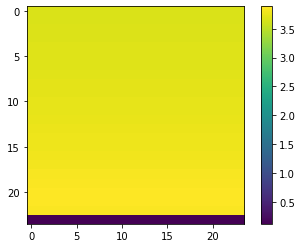

In [14]:
from matplotlib import pyplot as plt
import einops
from transformers import GPT2Model, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2 = GPT2Model.from_pretrained('gpt2')


def position_embedding(seq_len, model_pos_embedding):
    pos_ids = t.arange(seq_len)
    pos_emb = model_pos_embedding(pos_ids)

    pos_emb_1 = einops.repeat(pos_emb, "a h -> a b h", b = seq_len)
    pos_emb_2 = einops.repeat(pos_emb, "b h -> a b h", a = seq_len)

    out = t.einsum("abh,abh->ab",pos_emb_1, pos_emb_2)/(t.linalg.norm(pos_emb_1, dim=-1)  * t.linalg.norm(pos_emb_2, dim=-1))
    # out = out[450:,450:]
    plt.imshow(t.linalg.norm(pos_emb_1[1000:,1000:], dim=-1).detach())
    print(t.linalg.norm(pos_emb_1[-1,-1], dim=-1).detach())
    plt.colorbar()
    plt.show()
    return out
    # return (out - t.min(out)) / t.max(out)

    

# out = position_embedding(1024,gpt2.wpe)
# # out = position_embedding(512,model.pos_embedding)
# out = (t.abs(out) < 0.1)
# out = out.detach().numpy()

# plt.imshow(out, vmin = -1, vmax = 1)
# plt.colorbar()

out = position_embedding(1024,gpt2.wpe)


